In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import splitfolders
import math
import os
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random  
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from torchvision.utils import save_image, make_grid
from torchvision import transforms
from torchvision import models

In [2]:
input_folder = '/home/lexx/ComputerVision/project-4/content'
output_folder = '/home/lexx/ComputerVision/project-4/content_splited/'

def preprocessData(dirName, ext):
    allFiles = list()
    for root, dirs, files in os.walk(dirName):
        for file in files:
            if file.endswith(ext):
                allFiles.append(os.path.join(root, file))
    random.shuffle(allFiles)
    split = 0.9
    split_index = math.floor(len(allFiles) * split)
    training = allFiles[:split_index]
    testing = allFiles[split_index:]
    return training, testing
training, testing = preprocessData(input_folder, 'jpg')
for src in training:
    shutil.copy(src, output_folder + 'train/')
for src in testing:
    shutil.copy(src, output_folder + 'val/')

In [3]:
input_folder = '/home/lexx/ComputerVision/project-4/style'
output_folder = '/home/lexx/ComputerVision/project-4/style_splited/'
training, testing = preprocessData(input_folder, 'jpg')
for src in training:
    shutil.copy(src, output_folder + 'train/')
for src in testing:
    shutil.copy(src, output_folder + 'val/')

In [2]:
# utils functions ans model implementation
def calc_mean_std(features):
    """
    :param features: shape of features -> [batch_size, c, h, w]
    :return: features_mean, feature_s: shape of mean/std ->[batch_size, c, 1, 1]
    """

    batch_size, c = features.size()[:2]
    features_mean = features.reshape(batch_size, c, -1).mean(dim=2).reshape(batch_size, c, 1, 1)
    features_std = features.reshape(batch_size, c, -1).std(dim=2).reshape(batch_size, c, 1, 1) + 1e-6
    return features_mean, features_std


def adain(content_features, style_features):
    """
    Adaptive Instance Normalization
    :param content_features: shape -> [batch_size, c, h, w]
    :param style_features: shape -> [batch_size, c, h, w]
    :return: normalized_features shape -> [batch_size, c, h, w]
    """
    content_mean, content_std = calc_mean_std(content_features)
    style_mean, style_std = calc_mean_std(style_features)
    normalized_features = style_std * (content_features - content_mean) / content_std + style_mean
    return normalized_features


class VGGEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features
        self.slice1 = vgg[: 2]
        self.slice2 = vgg[2: 7]
        self.slice3 = vgg[7: 12]
        self.slice4 = vgg[12: 21]
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, images, output_last_feature=False):
        h1 = self.slice1(images)
        h2 = self.slice2(h1)
        h3 = self.slice3(h2)
        h4 = self.slice4(h3)
        if output_last_feature:
            return h4
        else:
            return h1, h2, h3, h4


class RC(nn.Module):
    """A wrapper of ReflectionPad2d and Conv2d"""
    def __init__(self, in_channels, out_channels, kernel_size=3, pad_size=1, activated=True):
        super().__init__()
        self.pad = nn.ReflectionPad2d((pad_size, pad_size, pad_size, pad_size))
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.activated = activated

    def forward(self, x):
        h = self.pad(x)
        h = self.conv(h)
        if self.activated:
            return F.relu(h)
        else:
            return h


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.rc1 = RC(512, 256, 3, 1)
        self.rc2 = RC(256, 256, 3, 1)
        self.rc3 = RC(256, 256, 3, 1)
        self.rc4 = RC(256, 256, 3, 1)
        self.rc5 = RC(256, 128, 3, 1)
        self.rc6 = RC(128, 128, 3, 1)
        self.rc7 = RC(128, 64, 3, 1)
        self.rc8 = RC(64, 64, 3, 1)
        self.rc9 = RC(64, 3, 3, 1, False)

    def forward(self, features):
        h = self.rc1(features)
        h = F.interpolate(h, scale_factor=2)
        h = self.rc2(h)
        h = self.rc3(h)
        h = self.rc4(h)
        h = self.rc5(h)
        h = F.interpolate(h, scale_factor=2)
        h = self.rc6(h)
        h = self.rc7(h)
        h = F.interpolate(h, scale_factor=2)
        h = self.rc8(h)
        h = self.rc9(h)
        return h


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg_encoder = VGGEncoder()
        self.decoder = Decoder()

    def generate(self, content_images, style_images, alpha=1.0):
        self.vgg_encode = self.vgg_encoder
        content_features = self.vgg_encoder(content_images, output_last_feature=True)
        style_features = self.vgg_encoder(style_images, output_last_feature=True)
        t = adain(content_features, style_features)
        t = alpha * t + (1 - alpha) * content_features
        out = self.decoder(t)
        return out

    @staticmethod
    def calc_content_loss(out_features, t):
        return F.mse_loss(out_features, t)

    @staticmethod
    def calc_style_loss(content_middle_features, style_middle_features):
        loss = 0
        for c, s in zip(content_middle_features, style_middle_features):
            c_mean, c_std = calc_mean_std(c)
            s_mean, s_std = calc_mean_std(s)
            loss += F.mse_loss(c_mean, s_mean) + F.mse_loss(c_std, s_std)
        return loss

    def forward(self, content_images, style_images, alpha=1.0, lam=10):
        content_features = self.vgg_encoder(content_images, output_last_feature=True)
        style_features = self.vgg_encoder(style_images, output_last_feature=True)
        t = adain(content_features, style_features)
        t = alpha * t + (1 - alpha) * content_features
        out = self.decoder(t)

        output_features = self.vgg_encoder(out, output_last_feature=True)
        output_middle_features = self.vgg_encoder(out, output_last_feature=False)
        style_middle_features = self.vgg_encoder(style_images, output_last_feature=False)

        loss_c = self.calc_content_loss(output_features, t)
        loss_s = self.calc_style_loss(output_middle_features, style_middle_features)
        loss = loss_c + lam * loss_s
        return loss

In [3]:
# dataset

transform = transforms.Compose([
    transforms.Resize(size=512),
    transforms.RandomCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


def denorm(tensor, device):
    std = torch.Tensor([0.229, 0.224, 0.225]).reshape(-1, 1, 1).to(device)
    mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(-1, 1, 1).to(device)
    res = torch.clamp(tensor * std + mean, 0, 1)
    return res


class ContentStyleDataset(Dataset):
    def __init__(self, content_dir, style_dir, num_range, transform=transform):
        content_images = glob.glob(os.path.join(content_dir, "*.jpg"))      
        style_images = glob.glob(os.path.join(style_dir, "*.jpg"))
        
        self.images_pairs = list(zip(content_images, style_images))[num_range[0]:num_range[1]]
        self.transform = transform

    def __len__(self):
        return len(self.images_pairs)

    def __getitem__(self, index):
        content_image, style_image = self.images_pairs[index]
        content_image = Image.open(content_image).convert("RGB") 
        style_image = Image.open(style_image).convert("RGB") 

        if self.transform:
            content_image = self.transform(content_image)
            style_image = self.transform(style_image)
        return content_image, style_image

Length of train image pairs: 32000
Start 1 epoch


0it [00:00, ?it/s]

[Epoch 1 Loss: 33.60172653198242
Start 2 epoch


0it [00:00, ?it/s]

[Epoch 2 Loss: 29.765684127807617
Start 3 epoch


0it [00:00, ?it/s]

[Epoch 3 Loss: 26.161882400512695
Start 4 epoch


0it [00:00, ?it/s]

[Epoch 4 Loss: 15.792074203491211
Start 5 epoch


0it [00:00, ?it/s]

[Epoch 5 Loss: 14.680702209472656
Start 6 epoch


0it [00:00, ?it/s]

[Epoch 6 Loss: 14.1513671875
Start 7 epoch


0it [00:00, ?it/s]

[Epoch 7 Loss: 13.842146873474121
Start 8 epoch


0it [00:00, ?it/s]

[Epoch 8 Loss: 15.29833984375
Start 9 epoch


0it [00:00, ?it/s]

[Epoch 9 Loss: 16.18710708618164
Start 10 epoch


0it [00:00, ?it/s]

[Epoch 10 Loss: 17.09510040283203
Start 11 epoch


0it [00:00, ?it/s]

[Epoch 11 Loss: 22.474536895751953
Start 12 epoch


0it [00:00, ?it/s]

[Epoch 12 Loss: 17.166109085083008
Start 13 epoch


0it [00:00, ?it/s]

[Epoch 13 Loss: 19.625699996948242
Start 14 epoch


0it [00:00, ?it/s]

[Epoch 14 Loss: 18.95960235595703
Start 15 epoch


0it [00:00, ?it/s]

[Epoch 15 Loss: 23.812232971191406
Start 16 epoch


0it [00:00, ?it/s]

[Epoch 16 Loss: 15.957305908203125
Start 17 epoch


0it [00:00, ?it/s]

[Epoch 17 Loss: 14.491668701171875
Start 18 epoch


0it [00:00, ?it/s]

[Epoch 18 Loss: 15.054216384887695
Start 19 epoch


0it [00:00, ?it/s]

[Epoch 19 Loss: 11.043313980102539
Start 20 epoch


0it [00:00, ?it/s]

[Epoch 20 Loss: 13.793902397155762
Loss saved in loss


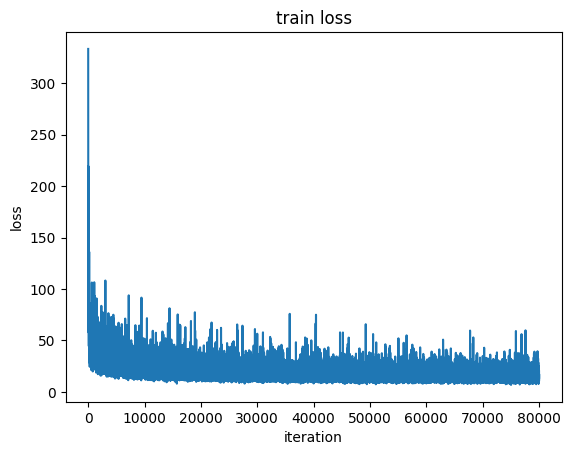

In [8]:
# training

batch_size = 8
epochs = 20
learning_rate = 5e-5
train_content_dir ='/home/lexx/ComputerVision/project-4/content_splited/train'
train_style_dir = '/home/lexx/ComputerVision/project-4/style_splited/train'
test_content_dir = '/home/lexx/ComputerVision/project-4/content_splited/val'
test_style_dir = '/home/lexx/ComputerVision/project-4/style_splited/val'


loss_dir = "loss"
model_state_dir = "model_state"

if not os.path.exists(loss_dir):
    os.mkdir(loss_dir)
if not os.path.exists(model_state_dir):
    os.mkdir(model_state_dir)

# set device on GPU if available, else CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = "cpu"

# to speed-up the training we will be using only 32000 context and style pairs of images 
num_train_range = (0, 32000)

# prepare dataset and dataLoader
train_dataset = ContentStyleDataset(train_content_dir, train_style_dir, num_range=num_train_range)
iters = len(train_dataset)
print(f'Length of train image pairs: {iters}')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# set model and optimizer
model = Model()
model = model.to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)

# start training
loss_list = []
for epoch in range(1, epochs + 1):
    print(f'Start {epoch} epoch')
    for i, (content, style) in tqdm(enumerate(train_loader, 1)):
        content = content.to(device)
        style = style.to(device)
        loss = model(content, style)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    print(f'[Epoch {epoch} Loss: {loss.item()}')
    torch.save(model.state_dict(), f'{model_state_dir}/{epoch}_epoch.pth')

# plot training loss
plt.plot(range(len(loss_list)), loss_list)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('train loss')
plt.savefig(f'{loss_dir}/train_loss.png')
with open(f'{loss_dir}/loss_log.txt', 'w') as f:
    for l in loss_list:
        f.write(f'{l}\n')
print(f'Loss saved in {loss_dir}')

Length of test image pairs: 5


0it [00:00, ?it/s]

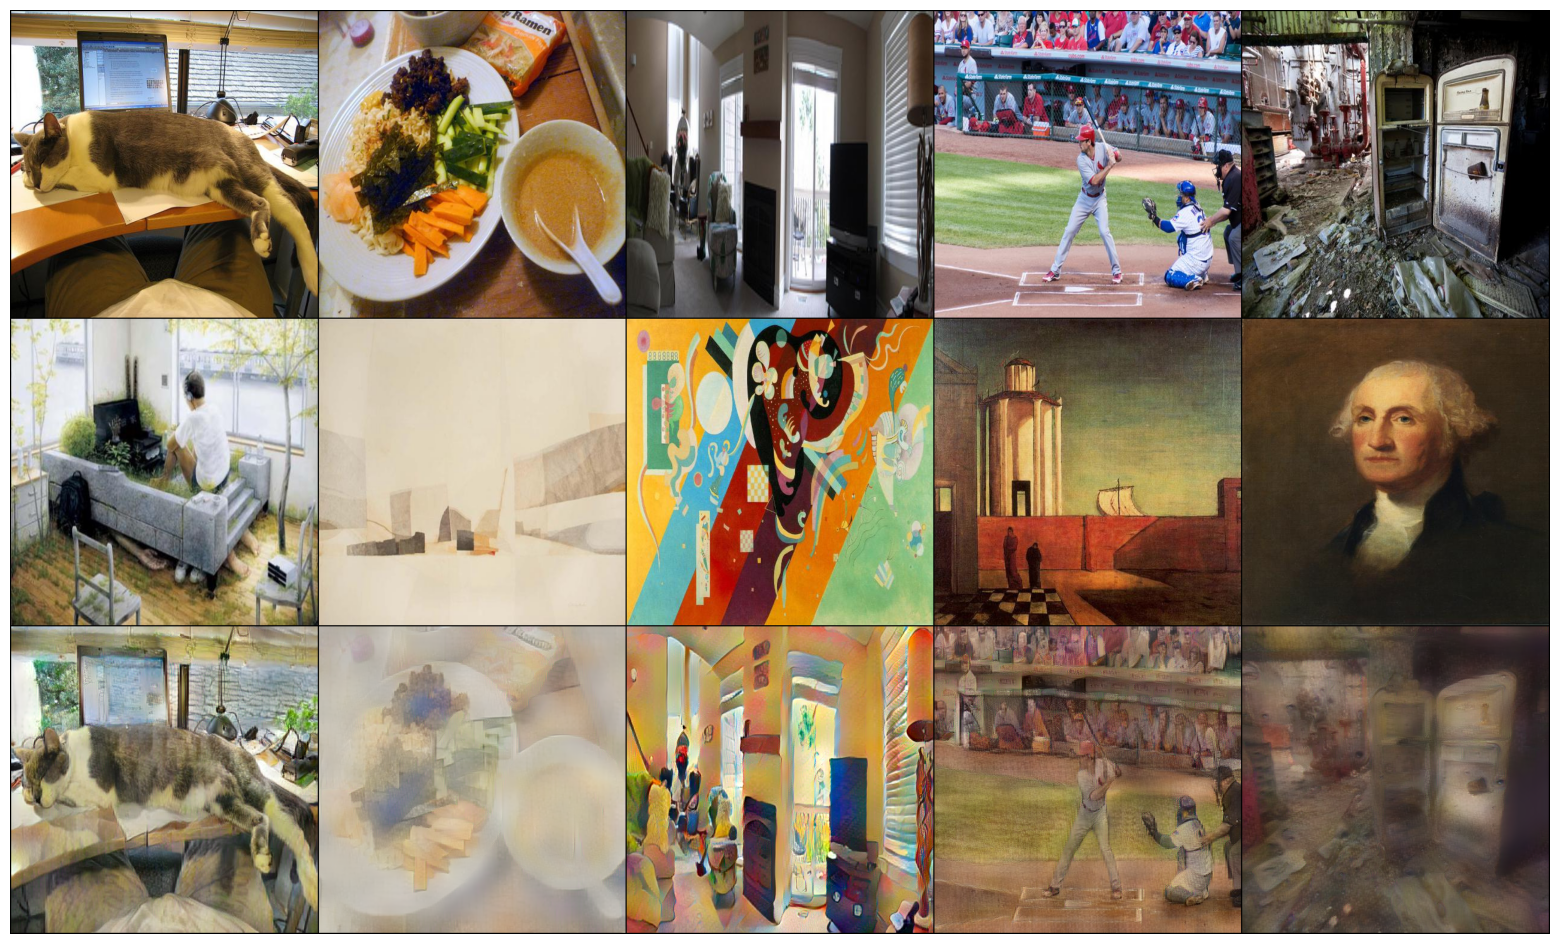

In [9]:
# test

model = model.eval()

# take 5 image pairs for the test set
num_test_range = (3201, 3206)

test_transform = transforms.Compose([
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])])

test_dataset = ContentStyleDataset(test_content_dir, test_style_dir, transform=test_transform, num_range=num_test_range)
iters = len(test_dataset)
print(f'Length of test image pairs: {iters}')

test_loader = DataLoader(test_dataset, batch_size=iters, shuffle=False)

for i, (content, style) in tqdm(enumerate(test_loader, 1)):
    content = content.to(device)
    style = style.to(device)
    with torch.no_grad():
        out = model.generate(content, style)
        content = denorm(content, device).detach().cpu()
        style = denorm(style, device).detach().cpu()
        out = denorm(out, device).detach().cpu()
        res = torch.cat([content, style, out], dim=0)
        grid_img = make_grid(res, nrow=iters)
        plt.figure(figsize=(20, 12))
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.axis("off")

In [10]:
torch.save(model, f'{model_state_dir}/full_model.pth')

In [ ]:
with open("model_adain.pte", "wb") as file:
    file.write(executorch_program.buffer)